# Logistic Regression

BUSMGT 7247

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Options for plots
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Seed the random number generator for reproducible results
random_state = 1000
np.random.seed(random_state)

In [2]:
def plot_decision_boundary(
    clf, X, y, classes, features, xlims,
    markers=['<', 'o', 's'],
    markercolors=['darkgreen', 'navy', 'darkred'],
    fillcolors=['lightgreen', 'cornflowerblue', 'lightcoral'],
    steps=1000, alpha=0.2, figsize=(15, 6)
):
    x1, x2 = np.meshgrid (np.linspace(*xlims[0], steps).reshape(-1, 1),
                          np.linspace(*xlims[1], steps).reshape(-1, 1))
    
    X_bound = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_bound)
    z = LabelEncoder().fit_transform(y_pred).reshape(x1.shape)
    
    plt.figure(figsize=figsize)
    
    for i, c in enumerate(classes):
        plt.plot(X.loc[y == c, features[0]], X.loc[y == c, features[1]],
                 color=markercolors[i], marker=markers[i],
                 linestyle='none', label=c)
    
    plt.contourf(x1, x2, z, levels=len(classes) + 1,
                 alpha=alpha, cmap=ListedColormap(fillcolors))
   
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend()
    plt.show()

## Load Data

### Data Description

The Bureau of Labor Statistics administers a National Longitudinal Survey of Youth that tracks individuals over the course of their lives.

The 1979 (NLSY79) cohort includes men and women born in the USA between 1957 and 1964.

In the data set, each row represents an individual that participates in the 1979 cohort.

| Attribute      | Definition                                                                                   |
| -------------- | -------------------------------------------------------------------------------------------- |
| ID             | Participant identifier assigned by BLS                                                       |
| Earnings       | Annual wage earnings 2014                                                                    |
| WeeksWorked    | Count of weeks worked in 2014                                                                |
| CumWeeksWorked | Cumulative weeks of work experience during study                                             |
| Education      | Years of education as of 2014                                                                |
| IQ             | Percentile on IQ test taken in 1979                                                          |
| Gender         | Participant's gender                                                                         |
| MSA            | Did the participant reside within an urban cluster or urbanized area in 2014?                |
| Library        | Did the participant, or someone in the participant's household, have a library card in 1979? |
| Esteem         | Score on the Rosenberg Self-Esteem Scale in 1979                                             |

In [6]:
df = pd.read_csv('nlsy.csv')
df.head()

,ID,Earnings,WeeksWorked,CumWeeksWorked,Education,IQ,Gender,MSA,Library,Esteem
0,83,0,3,553.0,10,2,Male,Yes,Yes,18
1,84,0,3,107.0,12,9,Male,Yes,Yes,20
2,87,11500,5,759.0,12,5,Male,Yes,Yes,22
3,105,20501,11,979.0,12,84,Female,Yes,Yes,19
4,178,59000,46,1010.0,16,99,Male,No,Yes,24


In [5]:
df.describe()

,ID,Earnings,WeeksWorked,CumWeeksWorked,Education,IQ,Esteem
count,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000
mean,4703.199497,24135.476111,37.160101,758.181894,13.135792,48.652976,22.242246
std,3103.388264,17758.127806,19.787004,245.824519,2.012128,30.266633,3.971056
min,83.000000,0.000000,0.000000,0.000000,7.000000,1.000000,12.000000
25%,2210.000000,11300.000000,21.000000,641.000000,12.000000,21.000000,19.000000
50%,4068.000000,21500.000000,51.000000,822.000000,12.000000,48.000000,22.000000
75%,6885.000000,35000.000000,52.000000,941.000000,14.000000,75.000000,25.000000
max,12303.000000,88000.000000,52.000000,1079.000000,20.000000,99.000000,30.000000


## Logistic Regression: Higher Education

In [8]:
# Return indicator of education category as a function of years of education
def higher_ed_category(years_education):
    if years_education >= 16:
        return 1
    else:
        return 0
    
# Create a variable to contain each participant's education category    
df['HigherEdCategory'] = df['Education'].apply(higher_ed_category)
df['HigherEdCategory'].value_counts(normalize=True)

0    0.830679
1    0.169321
Name: HigherEdCategory, dtype: float64

In [9]:
# Predict HigherEdCategory as a function of Earnings and WeeksWorked
X = df[['Earnings', 'WeeksWorked']]
y = df['HigherEdCategory']

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, test_size=0.25,
                                     stratify=y, random_state=random_state)

log_clf = LogisticRegression(random_state=random_state)
log_clf.fit(X_train, y_train)

LogisticRegression(random_state=1000)

In [10]:
# Calculate log odds and odds ratio
intercept = log_clf.intercept_[0]
coef = log_clf.coef_[0]

print(f'Intercept:   {intercept:.3f}\n'
      f'Earnings:     {coef[0]:.6f}\n'
      f'WeeksWorked: {coef[1]:.6f}\n')

x_earn = df['Earnings'].quantile(0.85)  # Gets the 85th percentile
x_weeks = df['WeeksWorked'].quantile(0.25)

proba = log_clf.predict_proba([[x_earn, x_weeks]])[0, 1]
oddsratio = proba / (1 - proba)
logodds = np.log(oddsratio)
linear_model = intercept + (coef[0] * x_earn) + (coef[1] * x_weeks)

print(f'Probability of (y = 1): {proba:.3f}\n'
      f'Odds ratio:             {oddsratio:.3f}\n'
      f'Log odds:               {logodds:.3f}\n'
      f'Linear model:           {linear_model:.3f}')

Intercept:   -6.182
Earnings:     0.000217
WeeksWorked: -0.071981

Probability of (y = 1): 0.839
Odds ratio:             5.208
Log odds:               1.650
Linear model:           1.650


In [11]:
# Evaluate on the training data
y_pred = log_clf.predict(X_test)
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.3f}\n'
      f'Precision: {precision_score(y_test, y_pred):.3f}\n'
      f'Recall:    {recall_score(y_test, y_pred):.3f}\n'
      f'F1:        {f1_score(y_test, y_pred):.3f}')

# Note: F1 score combines precision and recall,
# where F1 = 2 * (precision * recall) / (precision + recall)

Accuracy:  0.933
Precision: 0.830
Recall:    0.765
F1:        0.796


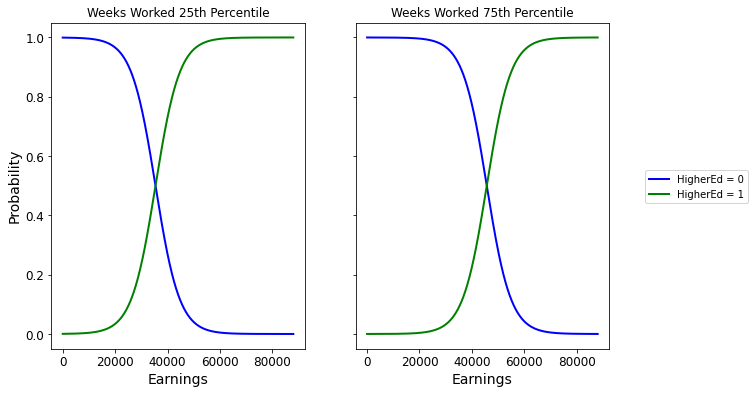

In [12]:
# Visualize the model's decision boundary for earnings
nrow = 1000

weeks_low = df['WeeksWorked'].quantile(0.25)
weeks_high = df['WeeksWorked'].quantile(0.75)

earnings = np.linspace(df['Earnings'].min(), df['Earnings'].max(), nrow)

X_weeks_low = np.column_stack((earnings, weeks_low * np.ones(nrow)))
X_weeks_high = np.column_stack((earnings, weeks_high * np.ones(nrow)))

y_proba_weeks_low = log_clf.predict_proba(X_weeks_low)
y_proba_weeks_high = log_clf.predict_proba(X_weeks_high)

fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
ha = ax[0].plot(earnings, y_proba_weeks_low[:, 0], 'b', linewidth=2, 
                label='HigherEd = 0')
hb = ax[0].plot(earnings, y_proba_weeks_low[:, 1], 'g', linewidth=2, 
                label='HigherEd = 1')
ax[0].set_xlabel('Earnings')
ax[0].set_ylabel('Probability')
ax[0].set_title('Weeks Worked 25th Percentile')

ax[1].plot(earnings, y_proba_weeks_high[:, 0], 'b', linewidth=2, 
           label='HigherEd = 0')
ax[1].plot(earnings, y_proba_weeks_high[:, 1], 'g', linewidth=2, 
           label='HigherEd = 1')
ax[1].set_xlabel('Earnings')
ax[1].set_title('Weeks Worked 75th Percentile')

fig.legend(*ax[0].get_legend_handles_labels(), 
           bbox_to_anchor=(1.1, 0.5), loc='center right')
plt.show()

### Exercise
Add other variables to the model, and track how the model changes.

## Multinomial Regression: Education Categories

In [13]:
# Return index of education category as a function of years of education
def education_category(years_education):
    if years_education < 16:
        return 'High School'
    elif years_education == 16:
        return 'Undergraduate'
    else:
        return 'Graduate'

    
# Create a variable to contain each participant's education category    
df['EducationCategory'] = df['Education'].apply(education_category)
df['EducationCategory'].value_counts(normalize=True)

High School      0.830679
Undergraduate    0.113160
Graduate         0.056161
Name: EducationCategory, dtype: float64

In [27]:
# Predict EducationCategory as a function of Earnings and WeeksWorked
df['EarningsSq'] = np.power(df['Earnings'], 2)
X = df[['Earnings', 'WeeksWorked']]
y = df['EducationCategory']

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, test_size=0.25,
                                     stratify=y, random_state=random_state)

softmax_clf = LogisticRegression(multi_class='multinomial', random_state=random_state,
                                 solver='lbfgs', C=2)
softmax_clf.fit(X_train, y_train)

LogisticRegression(C=2, multi_class='multinomial', random_state=1000)

In [28]:
# Evaluate on the training data
y_pred = softmax_clf.predict(X_test)
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.3f}')

Accuracy:  0.749


In [29]:
# Note: the first row in the output tallies the predicted classes
# for instances of the first actual class
print('Classes: Graduate, High School, and Undergraduate')
confusion_matrix(y_test, y_pred)

Classes: Graduate, High School, and Undergraduate


array([[  1,   5,  11],
       [ 24, 216,   8],
       [ 12,  15,   7]])

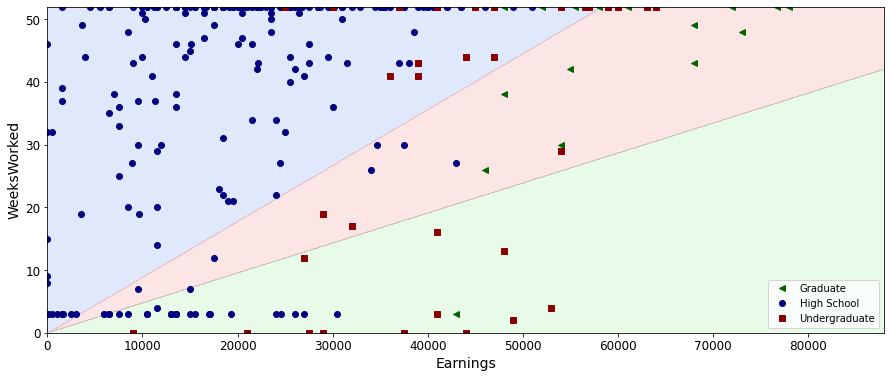

In [30]:
# Visualize decision boundaries
xlims = [
    [df['Earnings'].min(), df['Earnings'].max()],
    [df['WeeksWorked'].min(), df['WeeksWorked'].max()]
]

plot_decision_boundary(softmax_clf, X_test, y_test,
                       classes=['Graduate', 'High School', 'Undergraduate'],
                       features=['Earnings', 'WeeksWorked'],
                       xlims=xlims)                                           

### Exercise
Add other variables to the model. How does performance change as you incorporate new features?